In [1]:
%pylab inline
import pandas as pd
from pandas.api.types import is_categorical_dtype

from pyro.contrib.brm import defm, makedesc
from pyro.contrib.brm.design import metadata_from_df, metadata_from_cols, RealValued, Categorical, makedata
from pyro.contrib.brm.family import Normal, HalfCauchy, HalfNormal
from pyro.contrib.brm.formula import parse
from pyro.contrib.brm.model import model_repr
from pyro.contrib.brm.fit import fitted, Fit, get_scalar_param
from pyro.contrib.brm.priors import Prior
from pyro.contrib.brm.pyro_backend import backend as pyro_backend

from oed import *

Populating the interactive namespace from numpy and matplotlib


## Defining the model

Here we define the model and design space using existing brmp functionality. (We could of course provide a nicer interface.)

In [2]:
formula = parse('y ~ 1 + x1 + x2')

metadata = metadata_from_cols([
    RealValued('y'),
    Categorical('x1', ['a','b']),
    Categorical('x2', ['c','d']),
])

response = Normal
priors = [Prior(('b',), Normal(0.,1.)), Prior(('resp','sigma'), HalfNormal(.2))]

# Boiler plate.
model_desc = makedesc(formula, metadata, response, priors)

The design space for this model is:

In [3]:
metadata.levels(design_space_cols(formula, metadata))

[('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd')]

Build an empty data frame of the expected shape:

In [4]:
data_so_far = pd.DataFrame(dict(
    y=[],
    x1=pd.Categorical([]),
    x2=pd.Categorical([]),
))
assert len(data_so_far) == 0

There are three population level coefficients in this model:

In [5]:
print(model_repr(model_desc))

Population
----------------------------------------
Coef Priors:
intercept       | Normal(mu=0.0, sigma=1.0)
x1[b]           | Normal(mu=0.0, sigma=1.0)
x2[d]           | Normal(mu=0.0, sigma=1.0)
Response
----------------------------------------
Family: Normal()
Link:
  Parameter: mu
  Function:  identity
Priors:
sigma           | HalfNormal(sigma=0.2)


## A sequence of experiments

This shows the system doing something reasonable on this simple example.

### Round 1

Here we estimate the expected information gain for all designs. This currently uses a separate ANN for each design.

In [6]:
design, dstar, eigs, fit, plot_data = next_trial(formula, model_desc, data_so_far, metadata)
{'next_design': design, 'eigs': eigs}

{'next_design': ('a', 'c'),
 'eigs': [(('a', 'c'), -1.509823203086853),
  (('a', 'd'), -1.862811803817749),
  (('b', 'c'), -1.8076077699661255),
  (('b', 'd'), -1.8751298189163208)]}

The first trial to run is `(a,c)`. Since `a` and `c` are coded as zero, this trial will isolate the effect of the intercept coefficient.

We can also look at the marginals of the samples drawn from the prior:

In [7]:
print(marginals(fit))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -0.01  1.03 -2.06 -0.69  0.00  0.66  2.05
    b_x1[b]  0.01  1.03 -1.98 -0.69  0.02  0.68  2.03
    b_x2[d] -0.05  1.00 -1.92 -0.80 -0.06  0.69  1.95
      sigma  0.16  0.12  0.01  0.07  0.14  0.23  0.45


#### A look at what q is trained on...

For each design/coefficient pair, this plot shows the target ($\theta \in [-0.5,0.5]$) and the function learned by the corresponing ANN. (I fiddled with the priors and `eps` to make the unique shape exhibited by the `(a,c)`/coeff0 case more pronounced.)

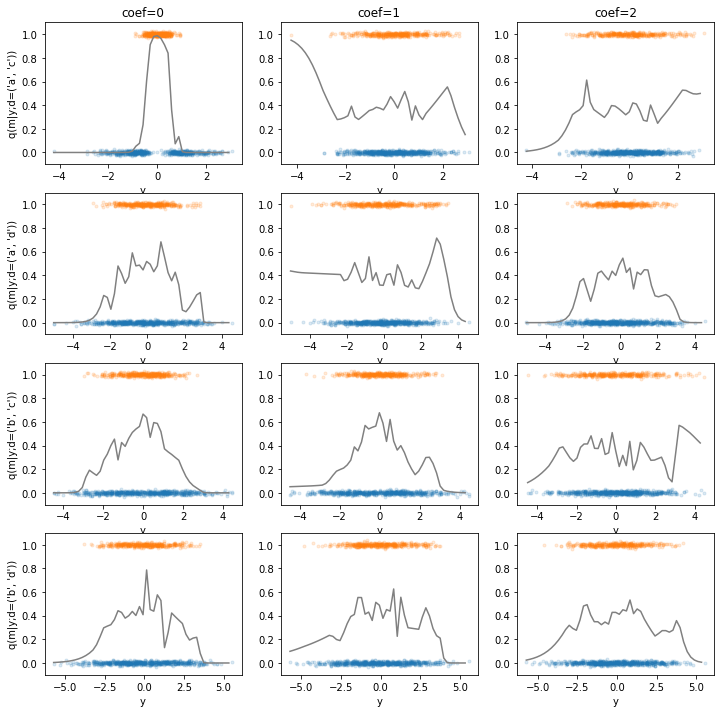

In [8]:
make_training_data_plot(plot_data)

Here we imagine running the suggested trial and extend `data_so_far` with the result. (I'm imagining that the intercept is about -3, and the other coefs are about 0.)

In [9]:
data_so_far2 = extend_df_with_result(formula, metadata, data_so_far, design, result=-3.0)
data_so_far2

,y,x1,x2
0,-3.0,a,c


### Round 2

We can now compute the next trial:

In [10]:
design2, dstar2, eigs2, fit2, plot_data2 = next_trial(formula, model_desc, data_so_far2, metadata)

warmup:   0%|          | 4/1500 [00:00<00:51, 29.19it/s, step size=1.53e-01, acc. prob=0.495]

sample: 100%|██████████| 1500/1500 [00:35<00:00, 42.00it/s, step size=3.75e-01, acc. prob=0.745]


We can look at the current posterior to confirm that the first trial significantly reduced our uncertainty about the intercept coef. Our beliefs about the other coefs were largely unchanged.

In [11]:
print(marginals(fit2))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -2.86  0.29 -3.23 -3.02 -2.94 -2.78 -1.98
    b_x1[b]  0.13  1.18 -2.22 -0.63  0.14  0.82  2.54
    b_x2[d]  0.03  0.98 -1.97 -0.64  0.04  0.69  1.99
      sigma  0.19  0.14  0.03  0.08  0.15  0.26  0.51


The next trial selected is `(b, c)`. We see that `(a, d)` was also close to been selected. This makes sense, as each of these involves exactly one of two coefs about which we have the most uncertainty.

In [12]:
{'next_design': design2, 'eigs': eigs2}

{'next_design': ('b', 'c'),
 'eigs': [(('a', 'c'), -1.294438123703003),
  (('a', 'd'), -1.0013236999511719),
  (('b', 'c'), -0.9918140769004822),
  (('b', 'd'), -1.2174887657165527)]}

Here's the training data seen by q again. The pairs `(a,d)`/coef2 and `(b,c)`/coef1 have the same distinctive shape as `(a,c)`/coef0 had in the first round. Also note that samples for coef0 are now mostly (or entirely) outside of `eps`.

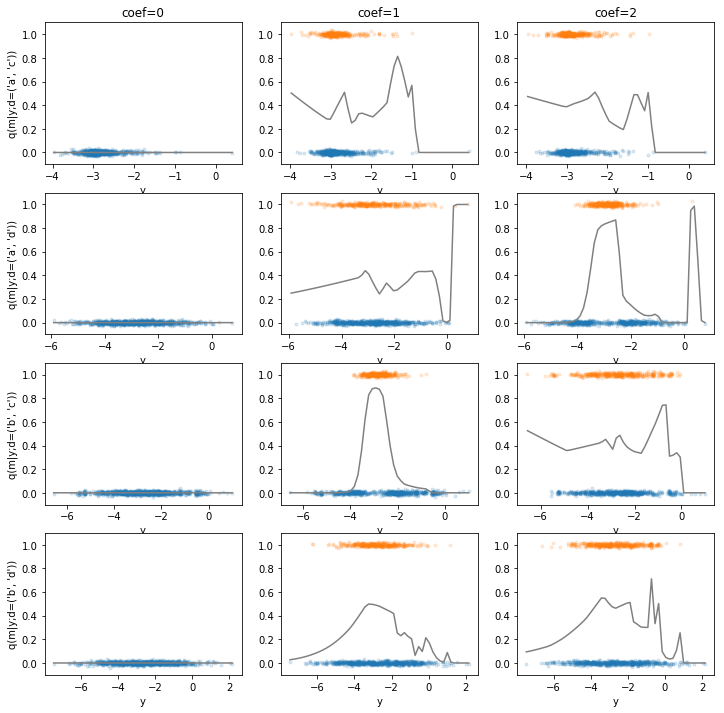

In [13]:
make_training_data_plot(plot_data2)

Run and record the suggested trial:

In [14]:
data_so_far3 = extend_df_with_result(formula, metadata, data_so_far2, design2, result=-3.1)
data_so_far3

,y,x1,x2
0,-3.0,a,c
0,-3.1,b,c


### Round 3

In [15]:
design3, dstar3, eigs3, fit3, plot_data3 = next_trial(formula, model_desc, data_so_far3, metadata)

warmup:   0%|          | 7/1500 [00:00<00:23, 63.34it/s, step size=1.01e-01, acc. prob=0.748]

sample: 100%|██████████| 1500/1500 [00:46<00:00, 32.17it/s, step size=2.30e-01, acc. prob=0.862]


As expected, the uncertainty about the coef isolated by the previous trial (coef1/`b_x1[b]`) was reduced:

In [16]:
print(marginals(fit3))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -2.89  0.23 -3.25 -3.03 -2.94 -2.80 -2.35
    b_x1[b] -0.18  0.28 -0.81 -0.32 -0.16 -0.03  0.36
    b_x2[d] -0.00  0.95 -1.91 -0.66 -0.01  0.65  1.90
      sigma  0.20  0.12  0.04  0.10  0.18  0.27  0.47


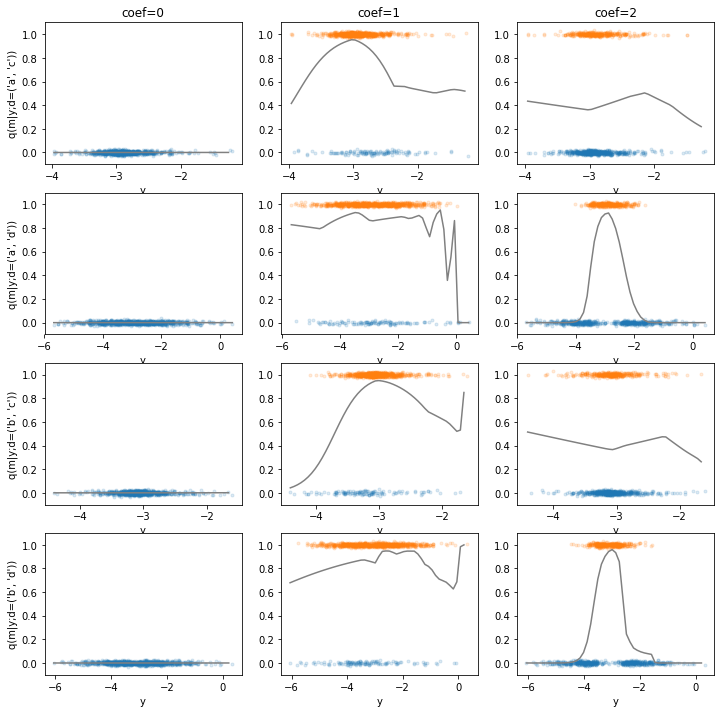

In [17]:
make_training_data_plot(plot_data3)

The proposed next trial is one of the two trials that isolates the effect of the final parameter about which there is a large amount of uncertainty. (The other such trial also has high EIG.)

In [18]:
{'next_design': design3, 'eigs': eigs3}

{'next_design': ('a', 'd'),
 'eigs': [(('a', 'c'), -0.9930403828620911),
  (('a', 'd'), -0.6990984082221985),
  (('b', 'c'), -0.9858314990997314),
  (('b', 'd'), -0.7086911797523499)]}

In [19]:
data_so_far4 = extend_df_with_result(formula, metadata, data_so_far3, design3, result=-2.95)
data_so_far4

,y,x1,x2
0,-3.00,a,c
0,-3.10,b,c
0,-2.95,a,d


### Round 4

In [20]:
design4, dstar4, eigs4, fit4, plot_data4 = next_trial(formula, model_desc, data_so_far4, metadata)

sample: 100%|██████████| 1500/1500 [00:43<00:00, 34.44it/s, step size=1.37e-01, acc. prob=0.857]


In [21]:
print(marginals(fit4))

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept -2.92  0.19 -3.24 -3.03 -2.96 -2.85 -2.44
    b_x1[b] -0.17  0.26 -0.82 -0.28 -0.13 -0.03  0.30
    b_x2[d] -0.02  0.25 -0.62 -0.11  0.02  0.11  0.43
      sigma  0.17  0.12  0.03  0.07  0.14  0.24  0.46
